In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import multiprocessing

/mnt/datadisk2/aglv/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
cd /mnt/datadisk2/aglv/aglv/lab_aglv/

/mnt/datadisk2/aglv/aglv/lab_aglv


In [3]:
from forintern.DataDaily import DataDaily
datadaily = DataDaily()
close = datadaily.adjclose
vol = datadaily.volume

load ./data_daily.h5...


In [4]:
def get_price_vol(datadaily):
    '''
    获取下面几个函数的数据对象  
    -> MultiIndex对象 level1-InstrumentID level2-date
    '''
    close = datadaily.adjclose.loc[20210101:20231231].T.stack()
    open = datadaily.adjopen.loc[20210101:20231231].T.stack()
    vol = datadaily.volume.loc[20210101:20231231].T.stack()
    data = pd.concat([close,open, vol], axis=1)
    data.columns = ['close', 'open', 'vol']
    
    return data

In [5]:
data = get_price_vol(datadaily)
data

close       open        vol
InstrumentID date                                     
BJ430017     20230531  17.804707  17.984553  153467.88
             20230601  16.725634  17.183423   54614.77
             20230602  16.921829  16.562138   27390.99
             20230605  16.709285  17.068976   14904.59
             20230606  16.627537  16.660236   11003.27
...                          ...        ...        ...
SZ301568     20231227  37.417994  36.855446   29027.85
             20231228  37.699268  38.304434   53146.44
             20231229  38.884029  37.503229   46111.99
SZ301578     20231228  71.698549  71.761340   90172.07
             20231229  69.249694  66.379240   72024.30

[3532614 rows x 3 columns]

In [71]:

def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
def relu(x):
    return pd.Series(np.where(x > 0, 1, 0), index=x.index)

def true_relu(x):
    return pd.Series(np.where(x > 0, x, 0), index=x.index)

def neg_relu(x):
    return pd.Series(np.where(x < 0, 1, 0), index=x.index)

def posi_or_neg(x):
    return pd.Series(np.where(x > 0, 1, -1), index=x.index)

def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

def leaky_relu(x, alpha=0.01):
    return pd.Series(np.where(x > alpha *x , x, alpha * x), index=x.index)

def p_dot(x, y, p=2):
    return np.power(np.dot(np.power(x, p), np.power(y, p)), 1/p)

def _handle_stockly(data_stock:pd.DataFrame, r_win=15):
    data_stock['vol_zs'] = (data_stock['vol'] - data_stock['vol'].rolling(r_win).sum()) / (data_stock['vol'].rolling(r_win).std() + 1e-10)
    data_stock['inday_ret'] = data_stock['close'] / data_stock['open']
    data_stock['night_ret'] = data_stock['open'] / data_stock['close'].shift(1)
    data_stock['weight'] = true_relu((data_stock['inday_ret'] - 1) * 100).rolling(r_win).mean()
    # data_stock['vol_zs_weight'] = relu(data_stock['vol_zs']).rolling(r_win).mean()

    def _f(x):
        y = data_stock['vol_zs'].loc[x.index]
        return np.dot(x, y)
    res = data_stock['weight'].rolling(r_win).apply(_f)

    del data_stock

    return res


def process_group(group, r_win=15):
    instrument_id, group_data = group
    return (instrument_id, _handle_stockly(group_data, r_win))

def price_vol_weight_corr_v1(data: pd.DataFrame, n_processes=64):
    grouped = list(data.groupby(level='InstrumentID'))
    with multiprocessing.Pool(processes=n_processes) as pool:
        results = list(tqdm(pool.imap(process_group, grouped), total=len(grouped)))

    factor_list = []
    for _, factor in results:
        factor_df = pd.DataFrame(factor.values, index=factor.index.get_level_values('date'), columns=[factor.index[0][0]])
        factor_list.append(factor_df)

    factor = pd.concat(factor_list, axis=1)

    return factor


In [72]:
fa = price_vol_weight_corr_v1(data)
fa

,BJ430017,BJ430047,BJ430090,BJ430139,BJ430198,BJ430300,BJ430418,BJ430425,BJ430476,BJ430478,...,SZ301529,SZ301533,SZ301548,SZ301550,SZ301555,SZ301558,SZ301559,SZ301566,SZ301568,SZ301578
date,,,,,,,,,,,,,,,,,,,,,
20210104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20231225,-1328.780609,-592.357931,-2325.080501,-833.366625,-1011.248375,-1716.215672,-1795.149071,-2385.948896,-634.760114,-2415.371097,...,-391.380318,-512.134507,-300.331457,-504.392083,-339.707076,-756.365445,-188.363487,NaN,NaN,NaN
20231226,-1342.728840,-545.235124,-2363.338368,-840.368653,-1053.206200,-1817.040579,-1816.090714,-2528.050916,-654.902610,-2420.584726,...,-353.225449,-515.471126,-302.696314,-487.726430,-357.312322,-765.977406,-186.660812,NaN,NaN,NaN
20231227,-1346.854795,-505.483619,-2419.940769,-844.838177,-1093.752383,-1909.389888,-1817.944192,-2695.484992,-686.301387,-2405.003333,...,-324.703940,-508.568926,-315.451877,-467.640146,-380.925985,-761.014158,-185.903866,NaN,NaN,NaN


In [73]:
fa.to_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/Sep/relu_indayret_r15sum_vol_zs_dot_r15.csv')

In [47]:
fa_2 = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/Sep/relu_nightret_r15mean_vol_zs_corr_r15.csv')
fa_2 = fa_2.set_index('date')

In [74]:
fa_3 = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/Sep/relu_nightret_r5mean_vol_zs_dot_r15.csv')
fa_3 = fa_3.set_index('date')

In [77]:
fa_2.corrwith(fa).dropna().mean()

-0.044151755933579284

In [94]:
def price_vol_corr(data:pd.DataFrame, r_win=15):
    '''
    捕捉量增价涨行情, 计算rolling一段时间的相关系数
    data: MultiIndex对象, l1:InstrumentID, l2:data, 日频数据
    '''
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    def relu(x):
        return pd.Series(np.where(x > 0, 1, 0), index=x.index)
    
    def tanh(x):
        return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
    
    def leaky_relu(x, alpha=0.1):
        return pd.Series(np.where(x > alpha *x , x, alpha * x), index=x.index)
    
    def p_dot(x, y, p=2):
        return np.power(np.dot(np.power(x, p), np.power(y, p)), 1/p)

    def _handle_stockly(data_stock:pd.DataFrame):
        data_stock['vol_zs'] = (data_stock['vol'] - data_stock['vol'].rolling(r_win).sum()) / (data_stock['vol'].rolling(r_win).std() + 1e-10)
        data_stock['inday_ret'] = data_stock['close'] / data_stock['open']
        data_stock['night_ret'] = data_stock['open'] / data_stock['close'].shift(1)
        data_stock['weight'] = relu((data_stock['night_ret'] - 1) * 100).rolling(r_win).mean()

        def split_vol(s:pd.Series):
            main_index = s.index[r_win:]
            sub_index = np.arange(r_win)
            multi_index = pd.MultiIndex.from_product(
                [main_index, sub_index],
                names=['main_index', 'sub_index']
            )
            
            res = pd.DataFrame(
                [s.loc[:date].iloc[:-r_win].values[i] for date in main_index for i in sub_index],
                index=multi_index,
                columns=s.columns
            )

            return res

        def _f(x):
            z = p_dot(data_stock['vol_zs'].loc[x.index], x)
            return z
        
        res = data_stock['weight'].rolling(r_win).corr(data_stock['vol_zs'].shift(2))

        del data_stock

        return res
    
    factor = data.groupby(level='InstrumentID').progress_apply(_handle_stockly)
    factor = factor.unstack(level='date')
    factor.index.names = ['InstrumentID', 's']
    factor = factor.droplevel('s')

    return factor.T

In [95]:
fa_p_vol_w_corr = price_vol_corr(data, r_win=15)
fa_p_vol_w_corr

InstrumentID,BJ430017,BJ430047,BJ430090,BJ430139,BJ430198,BJ430300,BJ430418,BJ430425,BJ430476,BJ430478,...,SZ301529,SZ301533,SZ301548,SZ301550,SZ301555,SZ301558,SZ301559,SZ301566,SZ301568,SZ301578
date,,,,,,,,,,,,,,,,,,,,,
20210104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20231225,0.871558,-0.565923,0.678836,-0.626142,-0.090953,0.255216,-0.631913,-0.599598,0.740186,0.907697,...,-0.022318,0.883966,-0.807284,-0.497225,-0.516783,0.838895,-0.699374,NaN,NaN,NaN
20231226,0.876755,-0.638181,0.692902,-0.419542,-0.237470,0.411489,-0.290631,-0.466158,0.825018,0.873752,...,-0.270597,0.880984,-0.844716,-0.382086,-0.512849,0.808888,-0.519914,NaN,NaN,NaN
20231227,0.873434,-0.675691,0.655787,-0.166250,-0.208582,0.527004,0.306072,0.034600,0.884110,0.848034,...,-0.493929,0.882183,-0.880816,-0.153249,-0.529764,0.767187,-0.438960,NaN,NaN,NaN


In [96]:
fa_p_vol_w_corr.to_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/Sep/relu_nightret_r5mean_vol_zs_corr_shift2_r15.csv')

In [92]:
def check_extrme_factor(factor:pd.DataFrame, date, rolling_day=10, is_large=True, check_num=10, check_period=5):
    '''
    检测某天的极端因子值的股票表现
    因子值按照向前rolling 10天的平均值进行排序 绘图显示前后5天的股票表现, 在jupyter中检测
    '''
    
    if 'date' in factor.columns:
        factor = factor.set_index('date')
    elif 'Date' in factor.columns:
        factor = factor.set_index('Date')

    if date not in factor.index:
        raise ValueError('日期为非交易日')
    
    # factor = factor.rolling(10).mean()
    factor_date = factor.loc[date]
    factor_date_sorted = factor_date.sort_values().dropna()

    if is_large:
        check_stock = factor_date_sorted.iloc[-check_num:].index
    else:
        check_stock = factor_date_sorted[factor_date_sorted != 0].iloc[:check_num].index
    
    close = datadaily.adjclose
    for stock in check_stock:
        date_id = close.index.get_loc(date)
        p_date = close.iloc[date_id-check_period : date_id+check_period+1, :].loc[:, stock]
        p_date.index = [str(i) for i in p_date.index]

        plt.plot(p_date)
        plt.title(stock)
        plt.show()

In [80]:
turn_std_agg = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/Sep_bertter/turnstd_agg5min_noavg_21_23_min.csv')

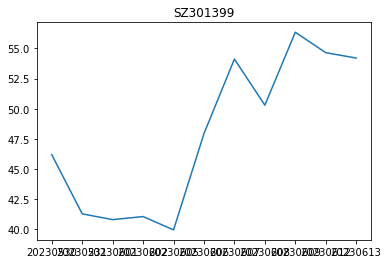

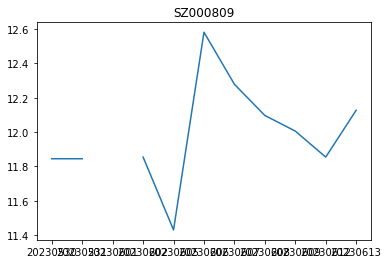

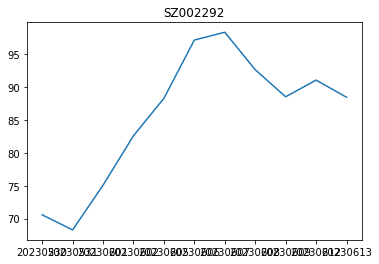

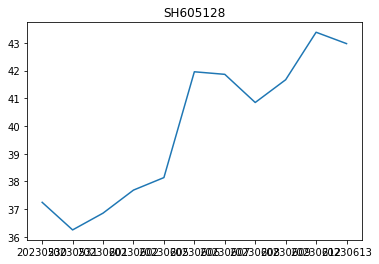

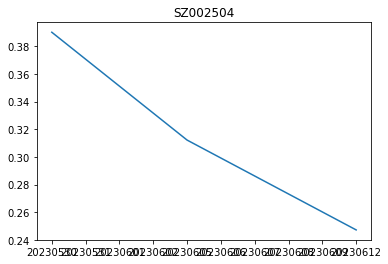

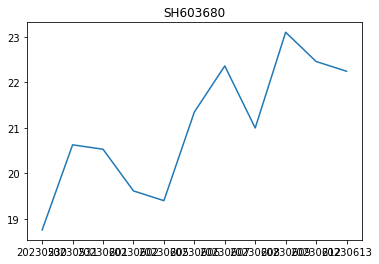

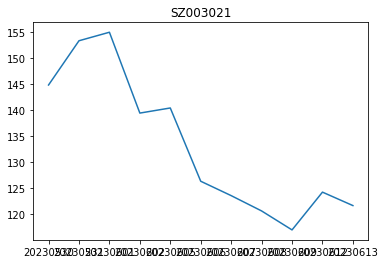

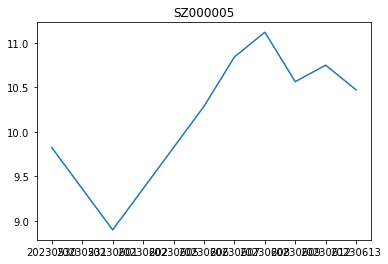

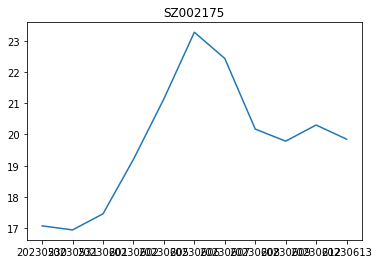

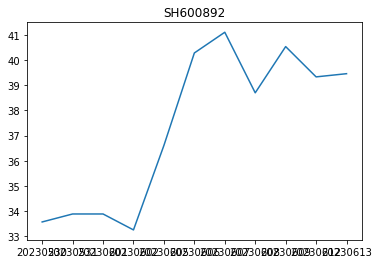

In [97]:
check_extrme_factor(turn_std_agg, 20230606, check_period=5)

In [49]:
zyhk = datadaily.close['SH601919']
zyhk

date
20171009     6.939981
20171010     7.149952
20171011     6.939981
20171012     6.979962
20171013     6.939981
              ...    
20240912    11.810000
20240913    11.920000
20240918    12.300000
20240919    12.660000
20240920    12.980000
Name: SH601919, Length: 1692, dtype: float64